<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Deep Learning in Finance MAP548 </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Project 1 -  Deep pricing and calibration </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>

# <font color='red'>PLEASE ENTER YOUR FULL NAMES HERE:</font>



- MANSARD Diane
- POTTIER Clément

<font color='red'>**DEADLINE: March 2 (5:00 pm)**</font>

<font color='red'>**PLease send both pdf ipynb files with name : Name1_Name2_Project1**</font>

# The two factor Bergomi model

The two factor Bergomi Model (L Bergomi, 2005) under the risk-neutral filtered probability space $(\Omega, \mathcal F,(\mathcal F_t)_{t\geq 0}, \mathbb Q )$  has the following dynamics:


\begin{equation}
  \begin{aligned}
    dS_t &= S_t\sqrt{V_t}dB_t, \quad S_0>0;\\
    X_t &= X_t^1 + X_t^2,\\
    V_t &= \xi \exp{\left(X_t-\frac{1}{2} \mathbb{V}[X_t] \right)},\\
      X_t^i &=  \eta_i\int_0^t e^{-\kappa_i(t-s)} dW_s,
  \end{aligned}
  \end{equation}

where $ B=\rho W + \sqrt{1-\rho^2} W^{\perp}$ with $(W,W^{\perp})$ a two-dimensional Brownian motion, $\rho \in [-1,1]$.

$X_t^i$ is a Ornstein–Uhlenbeck (Gaussian) process such that $X_t^i \sim \mathcal{N}(0, \eta_i^2\frac{(1-e^{-2\kappa_i t})}{2\kappa_i})$. Note that both $X^1$ and $X^2$ are driven by the same Brownian motion.

Recall $\mathbb V[(X+Y)] = \mathbb V[X] + \mathbb V[Y] + 2\mathbb {COV}[X,Y]$.

In addition, we fix $\kappa_2=2.6$, thus there are in total five calibratable model parameters: $(\xi, \kappa_1, \eta_1, \eta_2, \rho)$.

We are interested in computing the price of European style contingent claims, with payoff $g(S_T)$ for some function $g$:
$$
C_t = \mathbb{E} \left[g(S_T) \vert \mathcal F_t) \right].
$$

For European vanilla call options, with $g(x) = (x-K)^{+}$ with strike $K$; no closed form formula to compute $g(S_T)$

Suggested range of model parameters for training:

$\xi \in [0.03,0.25], \kappa_1 \in [10,60], \eta_1 \in [5,35],\eta_2 \in [1,5],\rho \in [-0.9,-0.1]$

# Your task

Inspired by the deep pricer for the one factor Bergomi model. Implement a deep pricer for the two factor Bergomi model. You have to generate your own training set using a scheme of your choice that you have to detail (use the fixed grid for strikes and maturities below).

Once your NN is trained, showcase the train and test error, and perform a calibration on the market implied volatility surface that was used in the one factor Bergomi and comment. 

Also provide/display the output prices of the NN of the set of parameters set 1, 2 and 3 below. 

You have to provide a notebook that compiles, together with the trained weights of your Neural Networks that we can load with the command: *model_iv.load_weights('2FBergomiNNWeights.h5')*. 

(!) The actual training of NN is not difficult, the difficult part is to get good data (and lots of it), so be careful about your simulation schemes (training might require a larger dataset than for 1 factor bergomi).

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## Let's start simulating Xt1 and Xt2 using a recursive method

Define the process for a 1-factor model:

$$
\widetilde X_t = e^{\kappa t}X_t = \int_0^t e^{\kappa s} dW_s,
$$

so that

$$
\widetilde X_{t_{j+1}} = \widetilde X_{t_j} + \int_{t_{j}}^{t_{j+1}}e^{\kappa s} dW_s =  \
    \widetilde X_{t_j}+\sqrt{\frac{e^{2 \kappa t_{j+1}}-e^{2 \kappa t_{j}}}{2\kappa}}Y_j,
$$

with $t_0 = 0, \quad t_N = T, \quad Y_i  \sim \mathcal{N}(0, 1)$ iid. Thus we first simulate $\widetilde X_{t_{j+1}}$ and then convert back to $X_t$ by:

$$
 X_t = e^{-\kappa t} \widetilde X_t.
$$

We then finally multiply by the corresponding eta to get the final value of the process for each Xt.

In [82]:
xi, kappa_1, eta_1, eta_2, rho, = 0.14, 35, 20, 3, -0.5
kappa_2 = 2.6
T = 2
n_steps = 1000 # number of time steps
N_sims = 50 # number of simulations

dt = T/n_steps
tt = np.linspace(0., T, n_steps + 1)

In [83]:
# Liste des valeurs à rechercher
times_to_find = [0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ]

# Dictionnaire pour stocker les indices
#indices = {time: np.where(tt == time)[0] for time in times_to_find}
indices = {time: np.argmin(np.abs(tt - time)) for time in times_to_find}# si approx numérique : 


# Afficher les indices
for time, index in indices.items():
    print(f"Time interval of {time}:", f"index {index} of the matrix tt")

Time interval of 0.1: index 50 of the matrix tt
Time interval of 0.3: index 150 of the matrix tt
Time interval of 0.6: index 300 of the matrix tt
Time interval of 0.9: index 450 of the matrix tt
Time interval of 1.2: index 600 of the matrix tt
Time interval of 1.5: index 750 of the matrix tt
Time interval of 1.8: index 900 of the matrix tt
Time interval of 2.0: index 1000 of the matrix tt


In [84]:
np.random.seed(42)

def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

w1 = gen_bm_path(n_steps,N_sims)

In [85]:
# Simulation of Xt1
exp1_Xt1 = np.exp(kappa_1*tt[1:])
exp2_Xt1 = np.exp(2*kappa_1*tt)

diff_exp2_Xt1 = np.diff(exp2_Xt1)
std_vec_Xt1 = np.sqrt(diff_exp2_Xt1/(2*kappa_1))[:,np.newaxis] #to be broadcasted columnwise 
exp1_Xt1 = exp1_Xt1[:,np.newaxis]
Xt1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt1)*np.cumsum(std_vec_Xt1*w1, axis = 0)))
Xt1 = eta_1*Xt1

In [86]:
# Simulation of Xt2
exp1_Xt2 = np.exp(kappa_2*tt[1:])
exp2_Xt2 = np.exp(2*kappa_2*tt)

diff_exp2_Xt2 = np.diff(exp2_Xt2)
std_vec_Xt2 = np.sqrt(diff_exp2_Xt2/(2*kappa_2))[:,np.newaxis] #to be broadcasted columnwise 
exp1_Xt2 = exp1_Xt2[:,np.newaxis]
Xt2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt2)*np.cumsum(std_vec_Xt2*w1, axis = 0)))
Xt2 = eta_2*Xt2

In [87]:
# Creation of Xt
Xt = Xt1 + Xt2

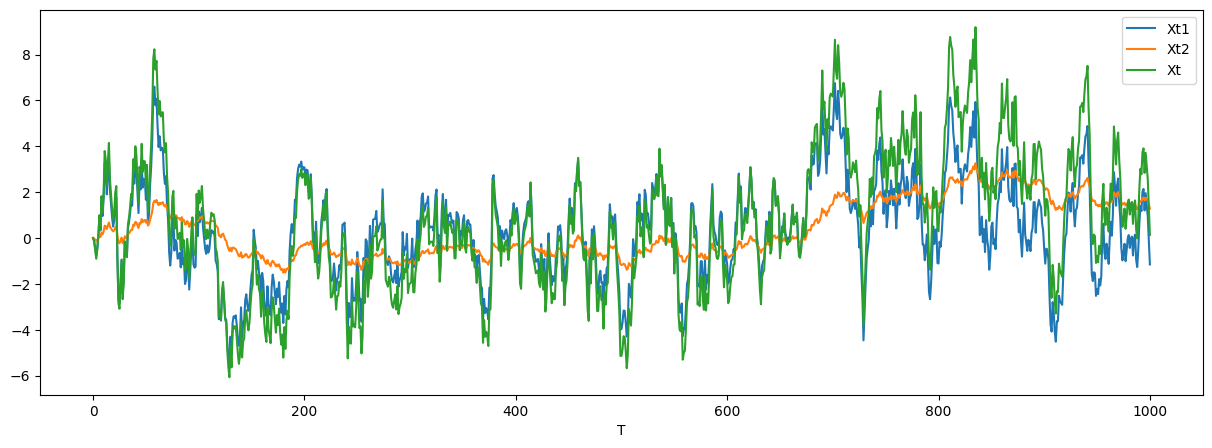

In [88]:
i_ind = 1
plt.figure(figsize=(15,5))
plt.plot(Xt1[:,i_ind],label='Xt1')
plt.plot(Xt2[:,i_ind],label='Xt2')
plt.plot(Xt[:,i_ind],label='Xt')
plt.xlabel('T')
plt.legend()
plt.show()

## Simulation of Vt and St with fixed parameters

$
\mathbb{V}[X_t] = \mathbb{V}[X_t^1] + \mathbb{V}[X_t^2] + 2 \mathbb{COV}[X_t^1, X_t^2]
$

$
\mathbb{V}[X_t] = \eta_1 \int_0^t e^{-\kappa_1 (t-s)} dW_s + \eta_2 \int_0^t e^{-\kappa_2 (t-s)} dW_s + 2\eta_1 \eta_2 \int_0^t e^{-\kappa_1 (t-s)} e^{-\kappa_2 (t-s)} ds
$

$
\mathbb{V}[X_t] = \eta_1^2 \frac{1 - e^{-2\kappa_1 t}}{2\kappa_1} + \eta_2^2 \frac{1 - e^{-2 \kappa_2 t}}{2 \kappa_2} + \eta_1 \eta_2 e^{-t(\kappa_1 + \kappa_2)}\int_0^t e^{(\kappa_1 + \kappa_2)s} ds
$

$
\mathbb{V}[X_t] = \eta_1^2 \frac{1 - e^{-2\kappa_1 t}}{2\kappa_1} + \eta_2^2 \frac{1 - e^{-2\kappa_2 t}}{2\kappa_2} + \eta_1 \eta_2 \frac{1 - e^{-t(\kappa_1 + \kappa_2)}}{\kappa_1 + \kappa_2}
$


In [89]:
var1 = eta_1**2*(1-np.exp(-2*kappa_1*tt))/(2*kappa_1)
var2 = eta_2**2*(1-np.exp(-2*kappa_2*tt))/(2*kappa_2)
covar = eta_1*eta_2*(1-np.exp(-(kappa_1+kappa_2)*tt))/(kappa_1+kappa_2) 
var = var1 + var2 + 2*covar

Vt = xi * np.exp(Xt - 0.5 * var[:, np.newaxis]) #variance calculated for each time step 

#Vt = xi * np.exp(Xt - 0.5 * np.var(Xt)) # avant


<span style="color:red">Ok de juste prendre la variance de Xt ? Le prof a donné des éléments plus détaillés pour la compo de la variance.</span>

In [90]:
S0 = 100
r = 0.02
np.random.seed(48)
w2 = gen_bm_path(n_steps,N_sims)

In [91]:
log_S = np.ones(N_sims).reshape(1,-1)*np.log(S0)
epochs_iter_j = tqdm(range(n_steps), desc="iteration", miniters=2000)
for j in epochs_iter_j:
    log_S_next = log_S[j]-0.5*Vt[j]*dt+np.sqrt(Vt[j]*dt)*\
        (rho*w1[j]+np.sqrt(1-rho**2)*w2[j]) #mettre w1 
    log_S=np.append(log_S,log_S_next.reshape(1,-1),axis=0)

S = np.exp(log_S)

iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

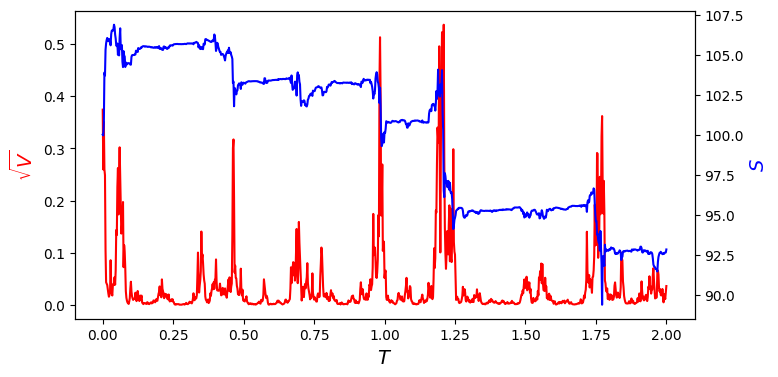

In [92]:
i_ind = 4 # The 4-th simulation
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax2 = ax.twinx()
lns2 = ax2.plot(tt,np.array(S[:,i_ind]), '-b',label = r'$S$')
lns1 = ax.plot(tt,np.sqrt(Vt[:,i_ind]), 'r',ls='-', label = r'$\sqrt{V}$')
labs = [l.get_label() for l in lns2+lns1]
ax.set_xlabel(r"$T$",size=14)
ax.set_ylabel(r'$\sqrt{V}$', color='red',size=14)
ax2.set_ylabel(r'$S$', color='blue',size=14)
plt.show()

## Let's now compute the prices of the option with the Monte Carlo method

With K=100 and T=2, the option price is:

In [93]:
K = 100
price = np.exp(-r*T) * np.mean(np.maximum(S[-1] - K, 0)) #Do the average of the payoffs of all the simulations
print(f"The option payoff is {price:.2f}")

The option payoff is 17.17


With K=100 and the requested time intervals:

In [94]:
for time, index in indices.items():
    price = np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - K, 0))
    print(f"The option payoff at time {time} is {price:.2f}")

The option payoff at time 0.1 is 2.24
The option payoff at time 0.3 is 4.44
The option payoff at time 0.6 is 7.49
The option payoff at time 0.9 is 10.63
The option payoff at time 1.2 is 12.65
The option payoff at time 1.5 is 13.30
The option payoff at time 1.8 is 15.18
The option payoff at time 2.0 is 17.87


Option prices at different strikes:

In [95]:
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])*S0

doit-on calibrer tous les prix avec exp(r(T-t)) ?

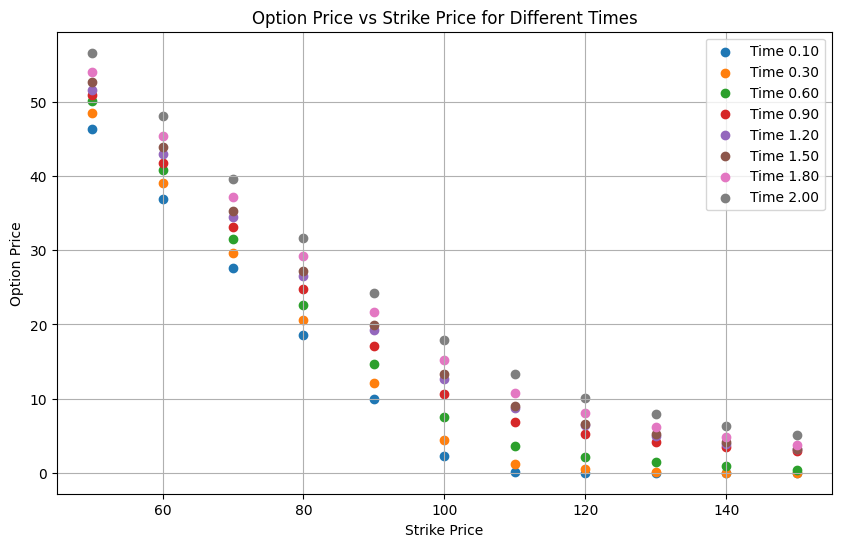

In [96]:
prices = {}

for time, index in indices.items():
    prices[time] = []
    for strike in strikes:
        price = np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - strike, 0))
        prices[time].append((strike, price))

# Plot the results
plt.figure(figsize=(10, 6))
for time, prices_data in prices.items():
    strikes, prices_values = zip(*prices_data)
    plt.scatter(strikes, prices_values, label=f'Time {time:.2f}')

plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Option Price vs Strike Price for Different Times')
plt.legend()
plt.grid(True)
plt.show()

## Let's implement the result in an array 

In [ ]:
parameters = [xi, kappa_1, eta_1, eta_2, rho]
x = np.array(parameters)

#x = np.array(parameters).reshape(1, -1) 

x.shape


(1, 5)

In [98]:
# Extraire tous les deuxièmes éléments de chaque tuple et les stocker dans une liste
values_list = [value[1] for sublist in prices.values() for value in sublist]

# Convertir la liste en un array NumPy
y = np.array(values_list)

# pour s'assurer que y est dans l'odre croissant et qu'on a bien que le strike comme target :
#y = np.array([price for time in sorted(prices.keys()) for _, price in prices[time]])


y.shape

(88,)

In [99]:
print(y)

[46.36621173 36.92498351 27.54251198 18.61323847  9.94871178  2.24400862
  0.12032704  0.          0.          0.          0.         48.48590654
 39.0135058  29.5819205  20.57234633 12.0626485   4.4441797   1.21622938
  0.52952451  0.15372067  0.          0.         50.16149823 40.82656991
 31.49164159 22.61175558 14.65676622  7.48580944  3.56373894  2.13274105
  1.50376556  0.92033254  0.33689952 50.99254937 41.82478089 33.06747557
 24.77174427 17.15428207 10.62677697  6.90083377  5.15988991  4.13704358
  3.51749178  2.93054764 51.62255648 42.96223606 34.42299763 26.56479029
 19.23071607 12.65477677  8.7297894   6.37551137  4.9016      3.91747268
  3.18419041 52.65263285 43.94019432 35.28640014 27.23139162 19.93752311
 13.29659718  8.97989001  6.63240147  5.19916226  4.1467352   3.19377015
 54.00502417 45.43935546 37.14387428 29.21195851 21.6408923  15.17575555
 10.74048151  8.0389672   6.15164894  4.76070228  3.78895722 56.63479297
 48.03479297 39.63780924 31.66480081 24.21859628 17

## Let's generate the dataset with moving parameters

<span style="color:red">Reprendre ce qui a été fait au-dessus (dans une fonction?) et le refaire avec une grille de paramètre</span>

In [134]:

N_sims = 50 # à augmenter
n_steps = 1000  
T = 2  
dt = T / n_steps
r = 0.02  

tt = np.linspace(0, T, n_steps + 1)  

times_to_find = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0]
indices = {time: np.argmin(np.abs(tt - time)) for time in times_to_find}

In [135]:
xi_grid = np.random.uniform(0.03, 0.25, N_sims)
kappa_1_grid = np.random.uniform(10, 60, N_sims)
kappa_2 = 2.6 
eta_1_grid = np.random.uniform(5, 35, N_sims)
eta_2_grid = np.random.uniform(1, 5, N_sims)
rho_grid = np.random.uniform(-0.9, -0.1, N_sims)

X = np.column_stack((xi_grid, kappa_1_grid, eta_1_grid, eta_2_grid, rho_grid))
print(X.shape)  # devrait donner (N_sims, 5)


(50, 5)


In [3]:
N=100
N_sims = 50
kappa_2 = 2.
T = 2
n_steps = 1000
dt = T / n_steps
tt = np.linspace(0, T, n_steps + 1)
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
indices = {time: np.argmin(np.abs(tt - time)) for time in [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0]}
S0 = 100
r = 0.02

In [4]:
np.random.seed(42)

def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

In [7]:
X_data = np.array([]).reshape(0, 5)
y_data = np.array([]).reshape(0, 88)

for i in tqdm(range(N), desc="Avancement", unit="iter"):
    xi = np.random.uniform(0.03, 0.25)
    kappa_1 = np.random.uniform(10, 60)
    eta_1 = np.random.uniform(5, 35)
    eta_2 = np.random.uniform(1, 5)
    rho = np.random.uniform(-0.9, -0.1)
    
    
    w1 = gen_bm_path(n_steps, N_sims)
    w2 = gen_bm_path(n_steps, N_sims)
    log_S = np.ones(N_sims).reshape(1,-1) * np.log(S0)
    
    log_S = np.ones(N_sims).reshape(1,-1) * np.log(S0)
    
    # sim Xt1
    exp1_Xt1 = np.exp(kappa_1*tt[1:])
    exp2_Xt1 = np.exp(2*kappa_1*tt)

    diff_exp2_Xt1 = np.diff(exp2_Xt1)
    std_vec_Xt1 = np.sqrt(diff_exp2_Xt1/(2*kappa_1))[:,np.newaxis] #to be broadcasted columnwise 
    exp1_Xt1 = exp1_Xt1[:,np.newaxis]
    Xt1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt1)*np.cumsum(std_vec_Xt1*w1, axis = 0)))
    Xt1 = eta_1*Xt1
    
    # sim Xt2
    exp1_Xt2 = np.exp(kappa_2*tt[1:])
    exp2_Xt2 = np.exp(2*kappa_2*tt)

    diff_exp2_Xt2 = np.diff(exp2_Xt2)
    std_vec_Xt2 = np.sqrt(diff_exp2_Xt2/(2*kappa_2))[:,np.newaxis] #to be broadcasted columnwise 
    exp1_Xt2 = exp1_Xt2[:,np.newaxis]
    Xt2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt2)*np.cumsum(std_vec_Xt2*w1, axis = 0)))
    Xt2 = eta_2*Xt2
    
    Xt = Xt1 + Xt2
    
    #calcul de Vt
    var1 = eta_1**2*(1-np.exp(-2*kappa_1*tt))/(2*kappa_1)
    var2 = eta_2**2*(1-np.exp(-2*kappa_2*tt))/(2*kappa_2)
    covar = eta_1*eta_2*(1-np.exp(-(kappa_1+kappa_2)*tt))/(kappa_1+kappa_2) 
    var = var1 + var2 + 2*covar

    Vt = xi * np.exp(Xt - 0.5 * var[:, np.newaxis])
    
    for j in range(n_steps):
        log_S_next = log_S[j] - 0.5 * Vt[j] * dt + np.sqrt(Vt[j] * dt) * (rho * w1[j] + np.sqrt(1 - rho**2) * w2[j])
        log_S = np.append(log_S, log_S_next.reshape(1,-1), axis=0)
    
    S = np.exp(log_S)
    prices = {}
    for time, index in indices.items():
        prices[time] = [np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - strike, 0)) for strike in strikes]
    
    values_list = [value for sublist in prices.values() for value in sublist]
    y = np.array(values_list)
    X = np.array([xi, kappa_1, eta_1, eta_2, rho]).reshape(1, -1)
    #if i == 0:
    #    X_data = X
    #    y_data = y.reshape(1, -1)
    #else:
    X_data = np.append(X_data, X, axis=0)
    y_data = np.append(y_data, y.reshape(1, -1), axis=0)
    pourcentage = (i + 1) / N * 100
    print(f"\rProgression : {pourcentage:.2f}%", end="", flush=True)

Avancement:   0%|          | 0/100 [00:00<?, ?iter/s]

Progression : 100.00%

In [9]:
X_data.shape
y_data.shape

(100, 88)

# Sample IV surface values

In [136]:
#based on the grid:
S0 = 100
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])*S0
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

indices = {time: int(time / dt) for time in maturities}

### parameter set 1

$\xi = 0.06, \kappa_1 =41.6, \eta_1 = 18.2428, \eta_2 = 3.43, \rho = -0.7$

### parameter set 2

$\xi = 0.1, \kappa_1 = 15.6, \eta_1 = 5.5857, \eta_2 = 2.2867, \rho = -0.4$

### parameter set 3

$\xi = 0.2, \kappa_1 = 54.6, \eta_1 = 31.3496, \eta_2 = 4.5733, \rho = -0.8$

In [105]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [106]:
def print_params(x):
    print(f'xi = {x[0]}', '\n', 
          f'kappa_1 = {x[1]}', '\n', 
          f'eta_1 = {x[2]}', '\n',
          f'eta_2 = {x[3]}', '\n',
          f'rho = {x[4]}', '\n')

In [143]:
def Bergomi2FactorTrainSet(x, S0, strikes, maturities, N_sims, n_steps, T, xi, kappa_1, eta_1, eta_2, rho):
    w1 = gen_bm_path(n_steps, N_sims)
    w2 = gen_bm_path(n_steps, N_sims)
    log_S = np.ones(N_sims).reshape(1,-1) * np.log(S0)
    
    log_S = np.ones(N_sims).reshape(1,-1) * np.log(S0)
    
    # sim Xt1
    exp1_Xt1 = np.exp(kappa_1[:, np.newaxis]*tt[1:])
    exp2_Xt1 = np.exp(2*kappa_1[:, np.newaxis]*tt)

    diff_exp2_Xt1 = np.diff(exp2_Xt1)
    std_vec_Xt1 = np.sqrt(diff_exp2_Xt1/(2*kappa_1[:, np.newaxis]))[:,np.newaxis] #to be broadcasted columnwise 
    exp1_Xt1 = exp1_Xt1[:,np.newaxis]
    Xt1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt1)*np.cumsum(std_vec_Xt1*w1, axis = 0)))
    Xt1 = eta_1*Xt1
    
    # sim Xt2
    exp1_Xt2 = np.exp(kappa_2 * tt[1:])
    exp2_Xt2 = np.exp(2 * kappa_2 * tt)
    diff_exp2_Xt2 = np.diff(exp2_Xt2)
    std_vec_Xt2 = np.sqrt(diff_exp2_Xt2 / (2 * kappa_2))[:, np.newaxis]
    exp1_Xt2 = exp1_Xt2[:, np.newaxis]
    Xt2 = np.concatenate((np.zeros((1, N_sims)), (1 / exp1_Xt2) * np.cumsum(std_vec_Xt2 * w2, axis=0)), axis=0)
    Xt2 = eta_2[:, np.newaxis] * Xt2
    
    Xt = Xt1 + Xt2
    
    #calcul de Vt
    var1 = eta_1[:, np.newaxis]**2 * (1 - np.exp(-2 * kappa_1[:, np.newaxis] * tt)) / (2 * kappa_1[:, np.newaxis])
    var2 = eta_2[:, np.newaxis]**2 * (1 - np.exp(-2 * kappa_2 * tt)) / (2 * kappa_2)
    covar = eta_1[:, np.newaxis] * eta_2[:, np.newaxis] * (1 - np.exp(-(kappa_1[:, np.newaxis] + kappa_2) * tt)) / (kappa_1[:, np.newaxis] + kappa_2)
    var = var1 + var2 + 2 * covar
    Vt = xi[:, np.newaxis] * np.exp(Xt - 0.5 * var.T)
    
    for j in range(n_steps):
        log_S_next = log_S[j] - 0.5 * Vt[j] * dt + np.sqrt(Vt[j] * dt) * (rho * w1[j] + np.sqrt(1 - rho**2) * w2[j])
        log_S = np.append(log_S, log_S_next.reshape(1,-1), axis=0)
    
    S = np.exp(log_S)
    prices = {}
    for time, index in indices.items():
        prices[time] = [np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - strike, 0)) for strike in strikes]
    
    values_list = [value for sublist in prices.values() for value in sublist]
    y = np.array(values_list)
    X = np.column_stack((xi*np.ones(N_sims), kappa_1*np.ones(N_sims), eta_1*np.ones(N_sims), eta_2*np.ones(N_sims), rho*np.ones(N_sims)))
    return X, y

In [144]:
X, Y = Bergomi2FactorTrainSet(X, S0, strikes, maturities, N_sims, n_steps, T, xi_grid, kappa_1_grid, eta_1_grid, eta_2_grid, rho_grid)


ValueError: operands could not be broadcast together with shapes (50,1,1000) (1000,50) 

## Preparation of the training data

In [ ]:
training_data = # importer les données d'entraînement
X=training_data[:,:4]
target_y=training_data[:,4:]
print(training_data.shape)
print('X shape:', X.shape)
print('Y shape:', target_y.shape)

Split the Data between training (85%) and testing (15%) and normalise inputs between $[-1,1]$ and center/standardise outputs. 

In [ ]:
#splitting the data to training and testing set
X_indexed = np.concatenate((np.arange(X.shape[0])[np.newaxis].T,X),axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
    X_indexed, target_y, test_size=0.15, random_state=42)

train_index = X_train[:,0].astype(int)
test_index = X_test[:,0].astype(int)
X_train = X_train[:,1:]
X_test = X_test[:,1:]

In [ ]:
#Normalising input data x to the interval of [-1, 1]
def input_norm_transform(x, x_min, x_max, norm_min, norm_max):
    return (x-x_min)/(x_max-x_min)*(norm_max-norm_min)+norm_min
def input_norm_transform_inv(x_norm, x_min, x_max, norm_min, norm_max):
    return (x_norm-norm_min)/(norm_max-norm_min)*(x_max-x_min)+x_min

x_max = np.array([np.max(X_train[:,0]),  np.max(X_train[:,1]),  np.max(X_train[:,2]), np.max(X_train[:,3])])
x_min = np.array([np.min(X_train[:,0]),  np.min(X_train[:,1]),  np.min(X_train[:,2]), np.min(X_train[:,3])])
x_norm_min = -1
x_norm_max = 1

x_train_transform = input_norm_transform(X_train, x_min, x_max, x_norm_min, x_norm_max)
x_test_transform = input_norm_transform(X_test, x_min, x_max, x_norm_min, x_norm_max)

In [ ]:
#Standardising output data y to the interval, so it is centred with variance 1
def output_norm_transform(y, mean, std):
    return (y-mean)/std
def output_norm_transform_inv(y_trans, mean, std):
    return y_trans*std+mean

y_mean = np.average(y_train,axis=0)
y_std = np.std(y_train,axis=0)

y_train_transform = output_norm_transform(y_train, y_mean, y_std)
y_test_transform = output_norm_transform(y_test, y_mean, y_std)

## Building of the Neural Network

In [ ]:
model_iv = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", input_shape=(5,)),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(y_train_transform.shape[1], activation="linear")
])

model_iv.summary()

c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,768 (18.62 KB)

 Trainable params: 4,768 (18.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def error_function(y_true, y_pred):
    return tf.sqrt(tf.math.reduce_mean((y_pred - y_true) ** 2))

model_iv.compile(optimizer="adam", loss=error_function)
train_hist = model_iv.fit(x_train_transform, y_train_transform, batch_size=200, epochs=50)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.0137
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.0118
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 1.0100
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 1.0083
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 1.0067
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.0051
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1.0037
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.0023
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.9997
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.9985
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.9974
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.9962
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.9952
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.9941
Epoch 16/50
1/1 ━━━━━━━━━━━━

In [ ]:
model_iv.load_weights('2FBergomiNNWeights_test.h5')

In [ ]:
NNParameters=[]
for i in range(0,len(model_iv.layers)):
    NNParameters.append(model_iv.layers[i].get_weights())

len(NNParameters[0][0])

### Transfer the learned NN to Numpy

In [ ]:
NNParameters=[]
for i in range(0,len(model_iv.layers)):
    NNParameters.append(model_iv.layers[i].get_weights())

NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(4)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

# References

1)  Lorenzo Bergomi. Smile dynamics II. Risk Magazine, 2005

2) Blanka Horvath, Aitor Muguruza, and Mehdi Tomas. Deep learning volatility: a deep neural 
network perspective on pricing and calibration in (rough) volatility models. Quantitativ 
Finance, 21(1):11–27, 20218

3) Ryan McCrickerd and Mikko S Pakkanen. Turbocharging monte carlo pricing for the rough 
bergomi model. Quantitative Finance, 18(11):1877–1886, 2018